# Problem 1: Constrain evolving dark matter

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from astropy import constants as const
from astropy.cosmology import Planck18
from astropy import units as u

In [2]:
omega_m_0 = 0.3
omega_L_0 = 0.7
eos_parameter_0 = -1

The two scenarios have to match at $z=0$ so we can assume any value for $H_0$. We can take the value of the Planck measuremnt

In [3]:
H0 = Planck18.H0

Let's define functions to calculate the equation-of-state parameter
$$ \omega(z, \omega_a) = \omega_0 + \omega_a (1 + \frac{1}{1+z}) $$

the hubble parameter
$$ H(z, \omega_a) = H_0 \sqrt{ \Omega_M (1 + z)^3 + \Omega_\Lambda (1+z)^{3 (1 + \omega(z, \omega_a))}} $$

and the luminosity distance

$$ d_L(z, \omega_a) = \frac{c}{H_0} \int_0 ^z \frac{H_0}{H(z', \omega_a)} dz' $$

In [4]:
def eos_parameter(z, eos_parameter_a):
    a = 1 / (1 + z)
    return eos_parameter_0 + eos_parameter_a * (1 - a)

def H(z, eos_parameter_a):
    a = 1 / (1 + z)
    omega_m = omega_m_0 * a ** (-3)
    omega_L = omega_L_0 * a ** (-3 * (1 + eos_parameter(eos_parameter_a, z)))
    return H0 * np.sqrt((omega_m + omega_L))
                   
def luminosity_distance(z, eos_parameter_a):
    
    def E_inverse(zprime):
        return H0 / H(zprime, eos_parameter_a)
    
    integral, integrating_err = quad(E_inverse, 0, z)
    proper_distance = const.c /H0 * integral
    
    return proper_distance * (1+z)

We can calculate the luminosity distance for the cases $\omega_a=0$ and $\omega_a=1$

In [68]:
for testz in [0, 0.5, 1]:
    dldif = luminosity_distance(testz, 0) - luminosity_distance(testz, 1)
    print(f'luminosity distance difference at z={testz:.1f}: {dldif.to("Mpc"):.2f}')

luminosity distance difference at z=0.0: 0.00 Mpc
luminosity distance difference at z=0.5: 71.71 Mpc
luminosity distance difference at z=1.0: 415.41 Mpc


We can see that there is a difference at higher redshifts. Let's compute the distance modulus
$$ \mu(d_L) = 5 \log_{10}(d_L / 10 \mathrm{pc}) $$
at redshift $z=0.7$. 

In [53]:
def distance_modulus(lum_dist):
    return 5 * np.log10(lum_dist / (10*u.pc))

In [54]:
test_z = 0.7
dl0 = luminosity_distance(test_z, 0)
dl1 = luminosity_distance(test_z, 1)
mu0 = distance_modulus(dl0)
mu1 = distance_modulus(dl1)
dmu = mu0 - mu1
print(f'To distinguish between the two scenarios we have to measure the distance modulus')
print(f'at z={test_z:.1f} with an accuracy of {dmu:.3f}')

To distinguish between the two scenarios we have to measure the distance modulus
at z=0.7 with an accuracy of 0.086


In [55]:
redshifts = np.linspace(0, 1, 100)
lum_dist_a0 = u.Quantity([luminosity_distance(ir, 0) for ir in redshifts])
lum_dist_a1 = u.Quantity([luminosity_distance(ir, 1) for ir in redshifts])

zoomed_redshifts = np.linspace(0.69, 0.71, 100)
zoomed_lum_dist_a0 = u.Quantity([luminosity_distance(ir, 0) for ir in zoomed_redshifts])
zoomed_lum_dist_a1 = u.Quantity([luminosity_distance(ir, 1) for ir in zoomed_redshifts])

/Users/jannisnecker/opt/miniconda3/envs/experimental_cosmology/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/jannisnecker/opt/miniconda3/envs/experimental_cosmology/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


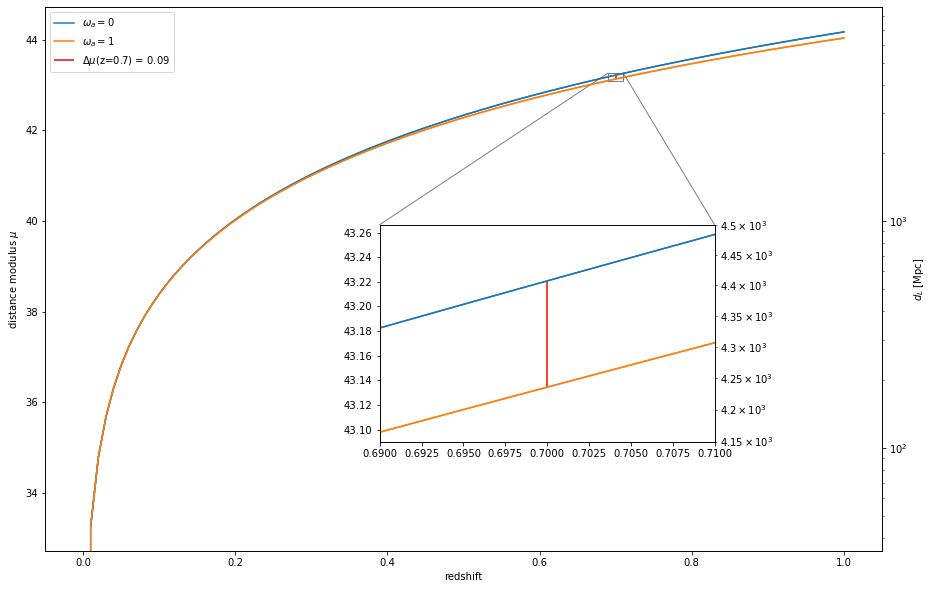

In [63]:
fig, ax = plt.subplots(figsize=(15, 10))

dl_unit = 'Mpc'

ax.plot(redshifts, distance_modulus(lum_dist_a0), label='$\omega_a = 0$', c='C0')
ax.plot(redshifts, distance_modulus(lum_dist_a1), label='$\omega_a = 1$', c='C1')
y1 = distance_modulus(luminosity_distance(0.7, 1))
y2 = y1 + dmu
ax.vlines(test_z, y1, y2, color='red', label=f"$\Delta \mu$(z={test_z:.1f}) = {dmu:.2f}")
ax.set_ylabel('distance modulus $\mu$')
ax.set_xlabel('redshift')
ax.legend()

zoomed_ax = ax.inset_axes([0.4, 0.2, 0.4, 0.4])
zoomed_ax.plot(zoomed_redshifts, distance_modulus(zoomed_lum_dist_a0), c='C0')
zoomed_ax.plot(zoomed_redshifts, distance_modulus(zoomed_lum_dist_a1), c='C1')

zoomed_ax.set_xlim([min(zoomed_redshifts), max(zoomed_redshifts)])
zoomed_ax.vlines(test_z, y1, y2, color='red')
ax.indicate_inset_zoom(zoomed_ax, edgecolor='k')

ax2 = ax.twinx()
ax2.plot(redshifts, lum_dist_a0.to(dl_unit))
ax2.plot(redshifts, lum_dist_a1.to(dl_unit))
ax2.set_ylabel(f'$d_L$ [{dl_unit}]')
ax2.set_yscale('log')

zoomed_ax2 = zoomed_ax.twinx()
zoomed_ax2.plot(zoomed_redshifts, zoomed_lum_dist_a0.to(dl_unit), c='C0')
zoomed_ax2.plot(zoomed_redshifts, zoomed_lum_dist_a1.to(dl_unit), c='C1')
zoomed_ax2.set_yscale('log')

plt.show()
plt.close()